**Bert**



In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers.optimization import AdamW
from transformers.optimization import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [3]:
df = pd.read_csv("/content/train_data.csv")

In [4]:
df.head()

,comment,toxic
0,Преступление и наказание\n,0.0
1,"И именно эти неработающие весы показывают, что...",0.0
2,"В Японии такие панельки, ебанько.\n",0.0
3,Еще у нас выявляют трещины с помощью белой кра...,0.0
4,"Дочитал до поезда в Норильск , дальше не стал\n",0.0


In [12]:
!git lfs install
!git clone https://huggingface.co/SkolkovoInstitute/russian_toxicity_classifier
# if you want to clone without large files – just their pointers
# prepend your git clone with the following env var:
GIT_LFS_SKIP_SMUDGE=1

git: 'lfs' is not a git command. See 'git --help'.

The most similar command is
	log
fatal: destination path 'russian_toxicity_classifier' already exists and is not an empty directory.


In [13]:
!pip install -q -U watermark
!pip install -qq transformers

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
tokenizer = AutoTokenizer.from_pretrained("SkolkovoInstitute/russian_toxicity_classifier")

model = AutoModelForSequenceClassification.from_pretrained("SkolkovoInstitute/russian_toxicity_classifier")

In [16]:
sentences=df.comment.values
labels = df.toxic.values

In [17]:
# Printing the original sentence.
print(' Original: ', sentences[0])

# Printing the tokenized sentence in form of list.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Преступление и наказание

Tokenized:  ['Преступление', 'и', 'наказание']
Token IDs:  [70596, 322, 16589]


In [18]:
input_ids = []
for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True,

                         )
    
 
    input_ids.append(encoded_sent)

In [19]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 256

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN , truncating="post", padding="post")


In [20]:
attention_masks = []

for sent in input_ids:

    att_mask = [int(token_id > 0) for token_id in sent]
   
    attention_masks.append(att_mask)

In [21]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,test_size=0.2)

In [22]:
#changing the numpy arrays into tensors for working on GPU. 
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Deciding the batch size for training.

batch_size = 16

#DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for our validation(test) set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

torch.Size([8647])

In [23]:
model =  AutoModelForSequenceClassification.from_pretrained("SkolkovoInstitute/russian_toxicity_classifier",
    num_labels = 2,   
    output_attentions = False,
    output_hidden_states = False,
)

# Running the model on GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [24]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [32]:
from transformers import get_linear_schedule_with_warmup

epochs = 20
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [28]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [34]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        model.zero_grad()        


        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels.long())
        

        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
  
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
  
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    541.    Elapsed: 0:00:17.
  Batch    80  of    541.    Elapsed: 0:00:33.
  Batch   120  of    541.    Elapsed: 0:00:50.
  Batch   160  of    541.    Elapsed: 0:01:07.
  Batch   200  of    541.    Elapsed: 0:01:23.
  Batch   240  of    541.    Elapsed: 0:01:40.
  Batch   280  of    541.    Elapsed: 0:01:57.
  Batch   320  of    541.    Elapsed: 0:02:13.
  Batch   360  of    541.    Elapsed: 0:02:30.
  Batch   400  of    541.    Elapsed: 0:02:47.
  Batch   440  of    541.    Elapsed: 0:03:04.
  Batch   480  of    541.    Elapsed: 0:03:20.
  Batch   520  of    541.    Elapsed: 0:03:37.

  Average training loss: 0.45
  Training epcoh took: 0:03:45

Running Validation...
  Accuracy: 0.88
  Validation took: 0:00:18

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    541.    Elapsed: 0:00:17.
  Batch    80  of    541.    Elapsed: 0:00:33.
  Batch   120  of    541.    Elapsed: 0:00:50.
  Batch   160  of    541.    El

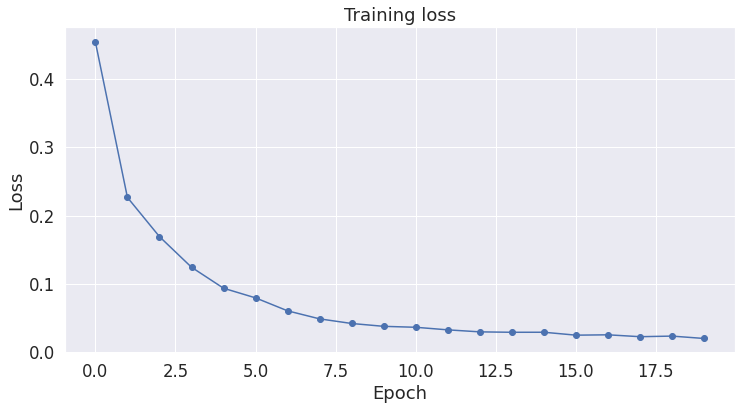

In [35]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [121]:
test_df = pd.read_csv("/content/test_data.csv")
test_df.head()
comment = test_df.comment

In [153]:
def preprocessing_for_bert(data):

    # create empty lists to store outputs
    input_ids = []
    attention_masks = []

    for sent in data:
      
        encoded_sent = tokenizer.encode_plus(
            sent,   
            add_special_tokens = True,         
            max_length= MAX_LEN  ,             
            pad_to_max_length = True,           
            return_attention_mask= True        
        )
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
        
    #convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    
    return input_ids,attention_masks

In [154]:
test_inputs, test_masks = preprocessing_for_bert(test_df.comment)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [155]:
test_dataset = TensorDataset(test_inputs, test_masks)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=16)

In [156]:
from functools import reduce
def bert_predict(model, test_dataloader):

    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits[0])
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    # probs = all_logits.sigmoid().cpu().numpy()
    return probs

#probs = all_logits.sigmoid().cpu().numpy()

In [157]:
probs = bert_predict(model, test_dataloader)
prob = (np.argmax(probs, axis=1))

In [164]:
submission = pd.DataFrame(prob,columns=['toxic'])
result = pd.concat([test_df, submission], axis=1)
result.drop(['comment'], axis=1,inplace =True)
result.toxic.astype('int32')

numpy.int64

In [165]:
result.to_csv("BertModel_proba.csv",index=False)